First 5 rows:
   flow_duration  Header_Length  Protocol Type  Duration           Rate  \
0       0.000000           0.00           1.00     64.00      19.481208   
1       0.000000          54.00           6.00     64.00     191.590718   
2       0.028989       23001.95          15.61     79.28  124783.255406   
3       0.000000          53.46           5.94     63.36       3.999280   
4       0.000000           0.00           1.00     64.00      48.982284   

           Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
0      19.481208    0.0              0.0              0.0              0.0   
1     191.590718    0.0              0.0              0.0              0.0   
2  124783.255406    0.0              0.0              0.0              0.0   
3       3.999280    0.0              0.0              1.0              0.0   
4      48.982284    0.0              0.0              0.0              0.0   

   ...       Std  Tot size           IAT  Number   Magnitue    Rad

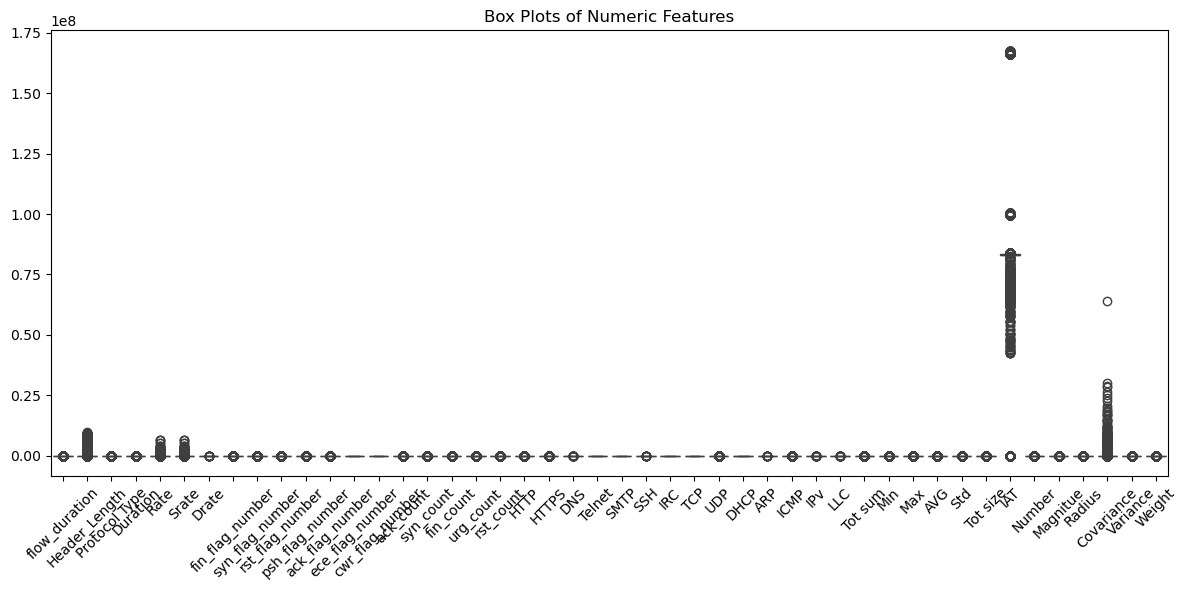

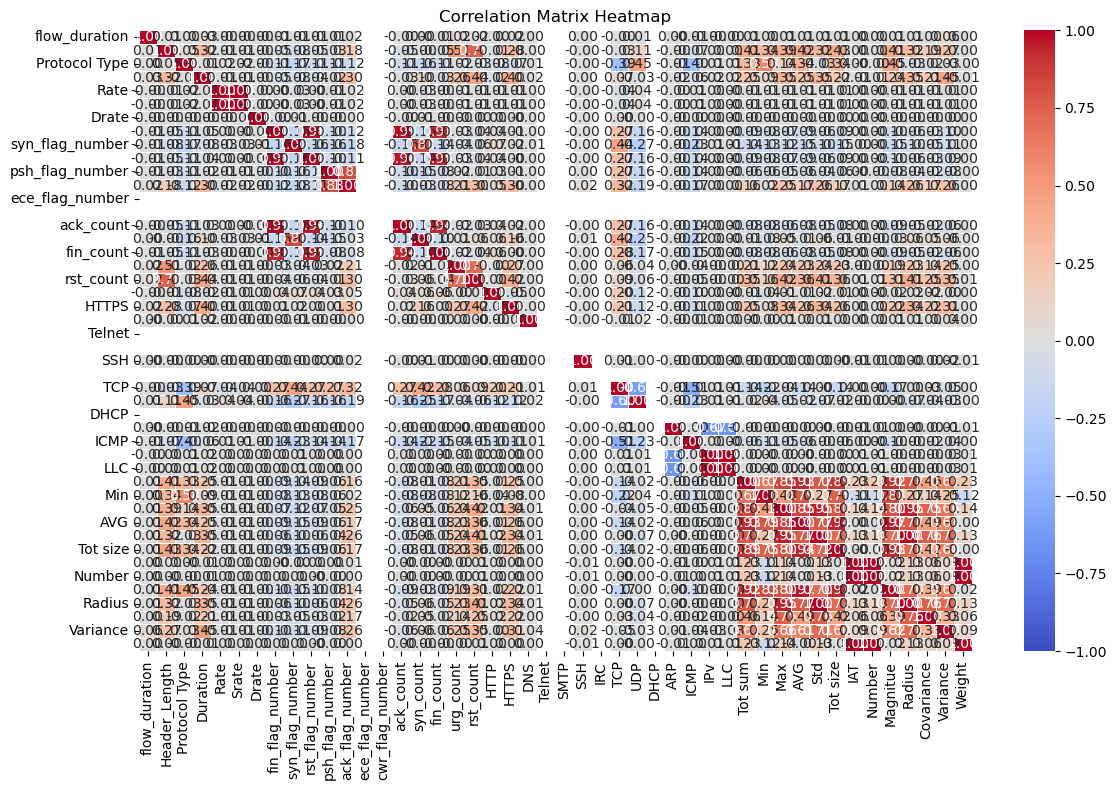


Missing values before cleaning:
flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
l

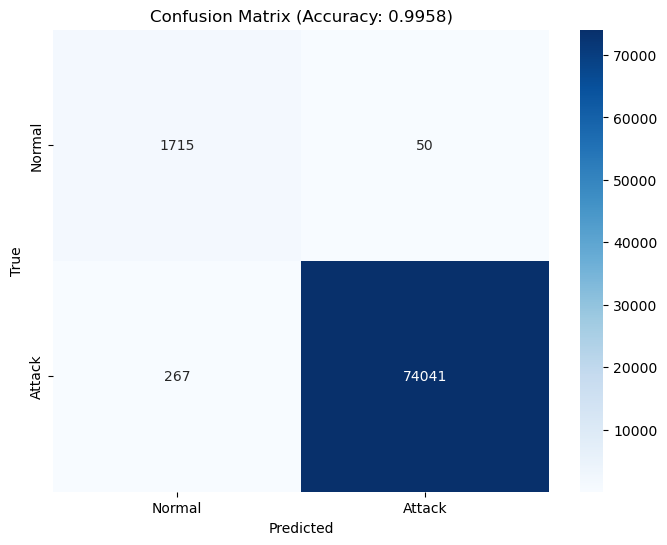

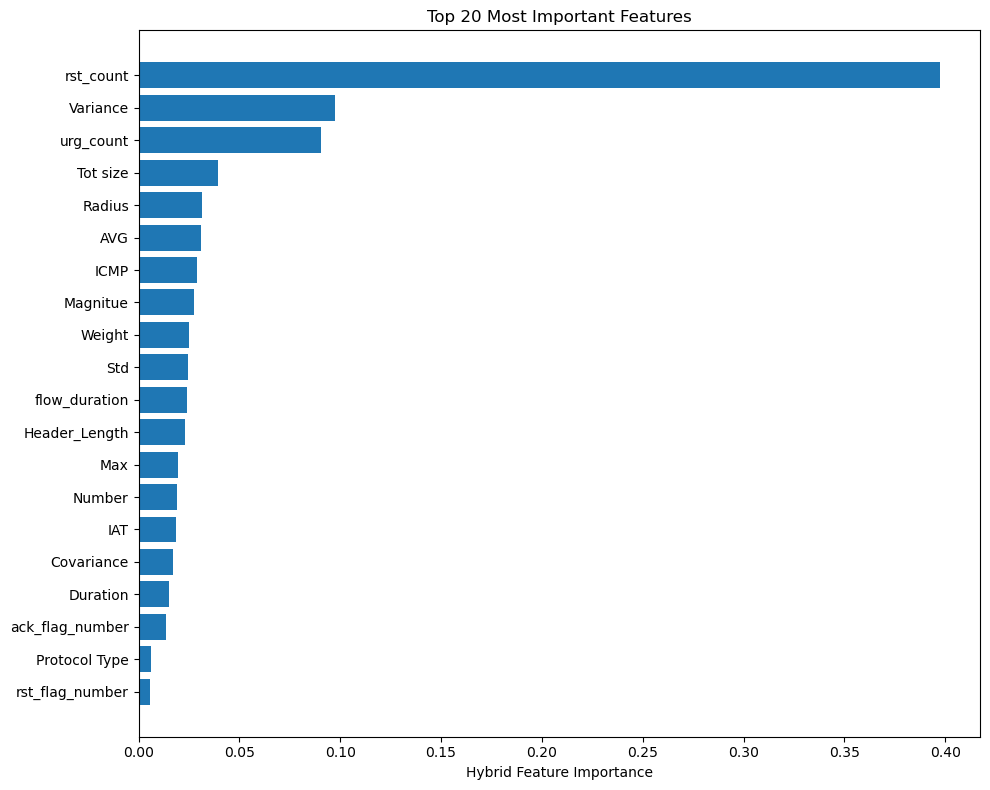


Top 20 most important features:
1. rst_count: 0.3974
2. Variance: 0.0973
3. urg_count: 0.0905
4. Tot size: 0.0395
5. Radius: 0.0315
6. AVG: 0.0307
7. ICMP: 0.0289
8. Magnitue: 0.0277
9. Weight: 0.0252
10. Std: 0.0247
11. flow_duration: 0.0242
12. Header_Length: 0.0232
13. Max: 0.0194
14. Number: 0.0190
15. IAT: 0.0187
16. Covariance: 0.0168
17. Duration: 0.0152
18. ack_flag_number: 0.0134
19. Protocol Type: 0.0062
20. rst_flag_number: 0.0054


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv('C:\\ProgramData\\anaconda3\\Lib\\site-packages\\pandas\\io\\parsers\\capstone\\part-00112-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')

# --------------------------
# 1. Data Exploration
# --------------------------
print("First 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())

# Visualize numeric features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include='number'))
plt.title('Box Plots of Numeric Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


# --------------------------
# 2. Data Preprocessing
# --------------------------
# Handle missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())

threshold = 0.3 * len(df)
df_clean = df.dropna(axis=1, thresh=threshold)

# Impute remaining missing values
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(df_clean.drop('label', axis=1)), 
                 columns=df_clean.drop('label', axis=1).columns)
y = df_clean['label']

# Remove duplicates
X = X.drop_duplicates()
y = y[X.index]

print(f"Rows after preprocessing: {len(X)}")

# --------------------------
# 3. Binary Classification Setup
# --------------------------
print("\n" + "="*50)
print("BINARY CLASSIFICATION")
print("="*50)

# Encode labels
le_binary = LabelEncoder()
y_encoded = le_binary.fit_transform(y)

# Create binary labels (0 = Normal, 1 = Attack)
benign_keywords = ['benign', 'normal', 'legitimate', 'BenignTraffic']
benign_indices = [i for i, cls in enumerate(le_binary.classes_) 
                 if any(kw in cls.lower() for kw in benign_keywords)]

if benign_indices:
    benign_index = benign_indices[0]
    y_binary = np.where(y_encoded == benign_index, 0, 1)
else:
    # Fallback if no benign class found
    y_binary = np.ones_like(y_encoded)  # Mark all as attacks

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, stratify=y_binary, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train_scaled, y_train)

# Verify class distribution
unique, counts = np.unique(y_balanced, return_counts=True)
print("\nClass distribution after SMOTE:")
print(f"Normal (0): {counts[0] if 0 in unique else 0}")
print(f"Attack (1): {counts[1] if 1 in unique else 0}")

# --------------------------
# 4. Model Training
# --------------------------
# Optimized base models
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=np.sum(y_balanced == 0) / np.sum(y_balanced == 1),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    tree_method='hist',
    device='cpu'  # Force CPU usage to avoid CUDA errors
)

# Stacking ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('random_forest', rf),
        ('xgboost', xgb)
    ],
    final_estimator=LogisticRegression(
        C=0.1,
        solver='liblinear',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Train the stacking model
print("\nTraining stacking ensemble...")
stacking_model.fit(X_balanced, y_balanced)

# --------------------------
# 5. Model Evaluation
# --------------------------
# Make predictions
y_pred = stacking_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*50)
print(f"Final Accuracy: {final_accuracy:.6f}")
print("="*50)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {final_accuracy:.4f})')
plt.show()

# Feature Importance
rf_model = stacking_model.named_estimators_['random_forest']
xgb_model = stacking_model.named_estimators_['xgboost']

rf_imp = rf_model.feature_importances_
xgb_imp = xgb_model.feature_importances_
hybrid_imp = (rf_imp + xgb_imp) / 2

# Plot top 20 most important features
top_n = min(20, len(hybrid_imp))
sorted_idx = np.argsort(hybrid_imp)[-top_n:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), hybrid_imp[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Hybrid Feature Importance')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} most important features:")
for i, idx in enumerate(sorted_idx[::-1]):
    print(f"{i+1}. {X.columns[idx]}: {hybrid_imp[idx]:.4f}")

Loading dataset...
Dataset shape: (253575, 47)

First 5 rows:
   flow_duration  Header_Length  Protocol Type  Duration           Rate  \
0       0.000000           0.00           1.00     64.00      19.481208   
1       0.000000          54.00           6.00     64.00     191.590718   
2       0.028989       23001.95          15.61     79.28  124783.255406   
3       0.000000          53.46           5.94     63.36       3.999280   
4       0.000000           0.00           1.00     64.00      48.982284   

           Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
0      19.481208    0.0              0.0              0.0              0.0   
1     191.590718    0.0              0.0              0.0              0.0   
2  124783.255406    0.0              0.0              0.0              0.0   
3       3.999280    0.0              0.0              1.0              0.0   
4      48.982284    0.0              0.0              0.0              0.0   

   ...       Std  

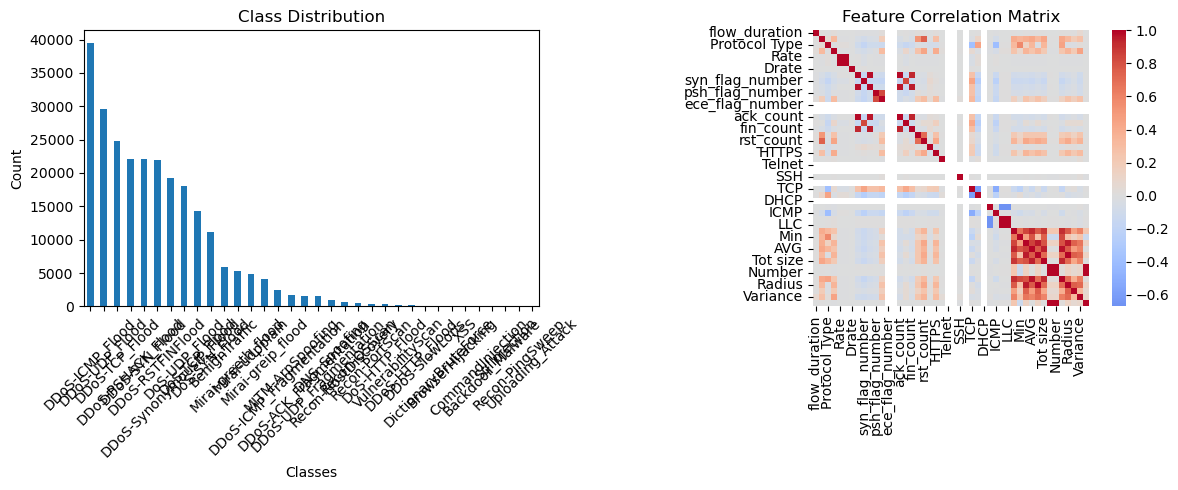


BINARY CLASSIFICATION SETUP
Benign class found: BenignTraffic

Binary class distribution:
Normal (0): 5882
Attack (1): 247693

Training binary classification model...
Training set size after SMOTE: 346770

Binary Classification Results:
Accuracy: 0.9958

Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.97      0.92      1765
      Attack       1.00      1.00      1.00     74308

    accuracy                           1.00     76073
   macro avg       0.93      0.98      0.96     76073
weighted avg       1.00      1.00      1.00     76073



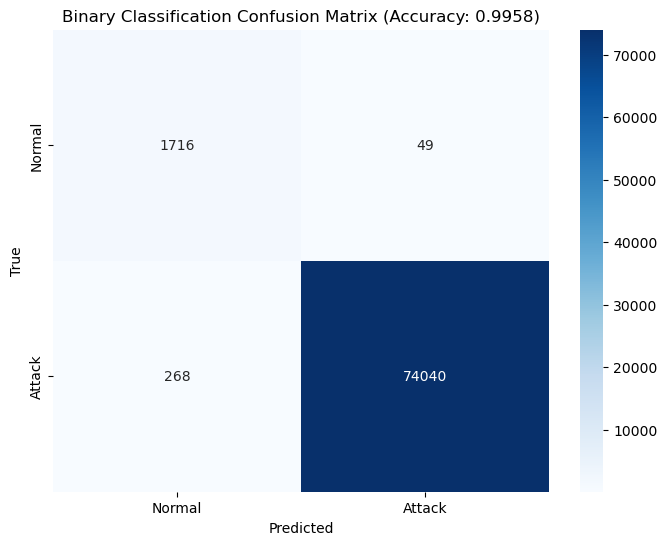


MULTICLASS CLASSIFICATION SETUP

Multiclass distribution:
Backdoor_Malware: 23
BenignTraffic: 5882
BrowserHijacking: 36
CommandInjection: 26
DDoS-ACK_Fragmentation: 1534
DDoS-HTTP_Flood: 133
DDoS-ICMP_Flood: 39408
DDoS-ICMP_Fragmentation: 2440
DDoS-PSHACK_Flood: 22151
DDoS-RSTFINFlood: 22004
DDoS-SYN_Flood: 22058
DDoS-SlowLoris: 127
DDoS-SynonymousIP_Flood: 19265
DDoS-TCP_Flood: 24764
DDoS-UDP_Flood: 29523
DDoS-UDP_Fragmentation: 1493
DNS_Spoofing: 972
DictionaryBruteForce: 71
DoS-HTTP_Flood: 401
DoS-SYN_Flood: 11074
DoS-TCP_Flood: 14319
DoS-UDP_Flood: 18023
MITM-ArpSpoofing: 1713
Mirai-greeth_flood: 5301
Mirai-greip_flood: 4123
Mirai-udpplain: 4797
Recon-HostDiscovery: 717
Recon-OSScan: 507
Recon-PingSweep: 15
Recon-PortScan: 425
SqlInjection: 17
Uploading_Attack: 3
VulnerabilityScan: 200
XSS: 30

Training multiclass classification model...
Training set size after SMOTE: 937924

Multiclass Classification Results:
Accuracy: 0.9930

Classification Report:
                         preci

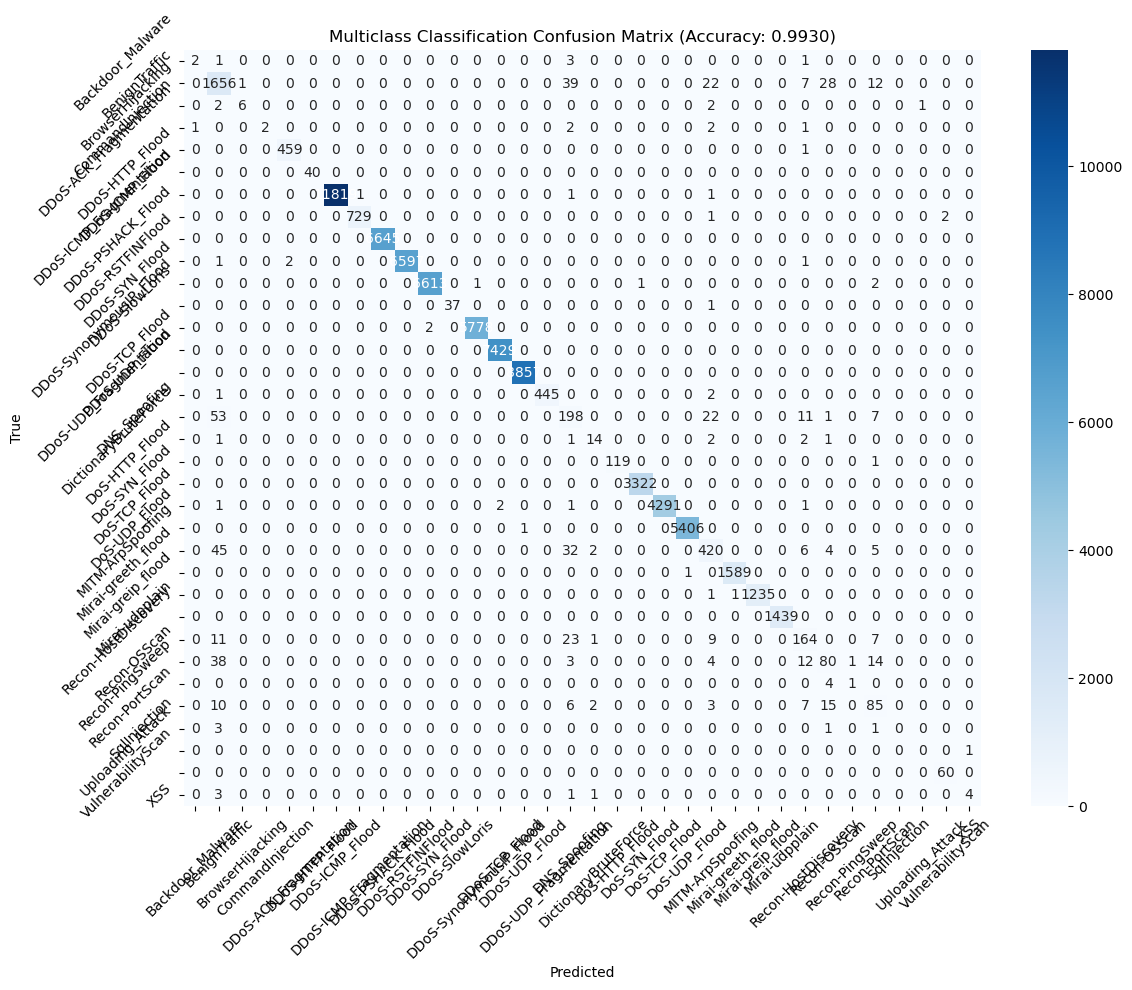


FINAL RESULTS SUMMARY
Binary Classification Accuracy: 0.9958
Multiclass Classification Accuracy: 0.9930


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION
# =============================================================================
DATA_PATH = 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\pandas\\io\\parsers\\capstone\\part-00112-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv'
RANDOM_STATE = 42
TEST_SIZE = 0.3

# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================
def load_and_preprocess_data(file_path):
    """Load and preprocess the dataset"""
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    
    print("Dataset shape:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())
    
    print("\nDataset info:")
    print(df.info())
    
    print("\nMissing values:")
    print(df.isnull().sum().sort_values(ascending=False))
    
    return df

def clean_data(df):
    """Clean the dataset by handling missing values and duplicates"""
    print("\nCleaning data...")
    
    # Remove columns with too many missing values (>30%)
    threshold = 0.3 * len(df)
    df_clean = df.dropna(axis=1, thresh=threshold)
    
    # Separate features and target
    if 'label' not in df_clean.columns:
        raise ValueError("Target column 'label' not found in dataset")
    
    X = df_clean.drop('label', axis=1)
    y = df_clean['label']
    
    # Handle missing values in features
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Remove duplicates
    X_clean = X_imputed.drop_duplicates()
    y_clean = y.loc[X_clean.index]
    
    print(f"Rows after cleaning: {len(X_clean)}")
    print(f"Features after cleaning: {X_clean.shape[1]}")
    
    return X_clean, y_clean

def explore_data(X, y):
    """Explore the dataset with visualizations"""
    print("\nData exploration...")
    
    # Class distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    y.value_counts().plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Correlation matrix for numeric features
    plt.subplot(1, 2, 2)
    corr_matrix = X.corr()
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
    plt.title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# =============================================================================
# BINARY CLASSIFICATION
# =============================================================================
def prepare_binary_classification(X, y):
    """Prepare data for binary classification"""
    print("\n" + "="*50)
    print("BINARY CLASSIFICATION SETUP")
    print("="*50)
    
    # Encode labels
    le_binary = LabelEncoder()
    y_encoded = le_binary.fit_transform(y)
    
    # Create binary labels (0 = Normal/Benign, 1 = Attack/Malicious)
    benign_keywords = ['benign', 'normal', 'legitimate', 'benigntraffic']
    benign_indices = [i for i, cls in enumerate(le_binary.classes_) 
                     if any(kw in cls.lower() for kw in benign_keywords)]
    
    if benign_indices:
        benign_index = benign_indices[0]
        y_binary = np.where(y_encoded == benign_index, 0, 1)
        print(f"Benign class found: {le_binary.classes_[benign_index]}")
    else:
        # If no clear benign class, use most frequent as normal
        most_frequent_idx = np.argmax(np.bincount(y_encoded))
        y_binary = np.where(y_encoded == most_frequent_idx, 0, 1)
        print(f"Using most frequent class as normal: {le_binary.classes_[most_frequent_idx]}")
    
    # Display class distribution
    unique, counts = np.unique(y_binary, return_counts=True)
    print(f"\nBinary class distribution:")
    print(f"Normal (0): {counts[0] if 0 in unique else 0}")
    print(f"Attack (1): {counts[1] if 1 in unique else 0}")
    
    return y_binary, le_binary

def train_binary_model(X, y_binary):
    """Train binary classification model"""
    print("\nTraining binary classification model...")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=TEST_SIZE, stratify=y_binary, random_state=RANDOM_STATE
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=RANDOM_STATE)
    X_balanced, y_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"Training set size after SMOTE: {len(X_balanced)}")
    
    # Create optimized models
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    xgb = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_STATE
    )
    
    # Stacking ensemble
    stacking_model = StackingClassifier(
        estimators=[
            ('random_forest', rf),
            ('xgboost', xgb)
        ],
        final_estimator=LogisticRegression(
            C=0.1,
            solver='liblinear',
            max_iter=1000,
            class_weight='balanced',
            random_state=RANDOM_STATE
        ),
        cv=5,
        n_jobs=-1
    )
    
    # Train model
    stacking_model.fit(X_balanced, y_balanced)
    
    # Evaluate model
    y_pred = stacking_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nBinary Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Binary Classification Confusion Matrix (Accuracy: {accuracy:.4f})')
    plt.show()
    
    return stacking_model, scaler, accuracy

# =============================================================================
# MULTICLASS CLASSIFICATION
# =============================================================================
def prepare_multiclass_classification(X, y):
    """Prepare data for multiclass classification"""
    print("\n" + "="*50)
    print("MULTICLASS CLASSIFICATION SETUP")
    print("="*50)
    
    # Encode labels
    le_multiclass = LabelEncoder()
    y_multiclass = le_multiclass.fit_transform(y)
    
    # Display class distribution
    unique, counts = np.unique(y_multiclass, return_counts=True)
    print(f"\nMulticlass distribution:")
    for class_idx, count in zip(unique, counts):
        class_name = le_multiclass.inverse_transform([class_idx])[0]
        print(f"{class_name}: {count}")
    
    return y_multiclass, le_multiclass

def train_multiclass_model(X, y_multiclass, le_multiclass):
    """Train multiclass classification model"""
    print("\nTraining multiclass classification model...")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_multiclass, test_size=TEST_SIZE, stratify=y_multiclass, random_state=RANDOM_STATE
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=1)
    X_balanced, y_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"Training set size after SMOTE: {len(X_balanced)}")
    
    # Create optimized models for multiclass
    rf = RandomForestClassifier(
        n_estimators=150,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    xgb = XGBClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=0.1,
        use_label_encoder=False,
        eval_metric='mlogloss',
        objective='multi:softmax',
        num_class=len(np.unique(y_balanced)),
        random_state=RANDOM_STATE
    )
    
    # Stacking ensemble
    stacking_model = StackingClassifier(
        estimators=[
            ('random_forest', rf),
            ('xgboost', xgb)
        ],
        final_estimator=LogisticRegression(
            C=0.1,
            solver='lbfgs',
            max_iter=1000,
            class_weight='balanced',
            multi_class='multinomial',
            random_state=RANDOM_STATE
        ),
        cv=3,
        n_jobs=-1
    )
    
    # Train model
    stacking_model.fit(X_balanced, y_balanced)
    
    # Evaluate model
    y_pred = stacking_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nMulticlass Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le_multiclass.classes_, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_multiclass.classes_,
                yticklabels=le_multiclass.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Multiclass Classification Confusion Matrix (Accuracy: {accuracy:.4f})')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return stacking_model, scaler, accuracy

# =============================================================================
# MAIN EXECUTION
# =============================================================================
def main():
    """Main execution function"""
    try:
        # Load and preprocess data
        df = load_and_preprocess_data(DATA_PATH)
        X, y = clean_data(df)
        
        # Explore data
        corr_matrix = explore_data(X, y)
        
        # Binary Classification
        y_binary, le_binary = prepare_binary_classification(X, y)
        binary_model, binary_scaler, binary_accuracy = train_binary_model(X, y_binary)
        
        # Multiclass Classification
        y_multiclass, le_multiclass = prepare_multiclass_classification(X, y)
        multiclass_model, multiclass_scaler, multiclass_accuracy = train_multiclass_model(X, y_multiclass, le_multiclass)
        
        # Summary
        print("\n" + "="*60)
        print("FINAL RESULTS SUMMARY")
        print("="*60)
        print(f"Binary Classification Accuracy: {binary_accuracy:.4f}")
        print(f"Multiclass Classification Accuracy: {multiclass_accuracy:.4f}")
        print("="*60)
        
        return {
            'binary_model': binary_model,
            'multiclass_model': multiclass_model,
            'binary_scaler': binary_scaler,
            'multiclass_scaler': multiclass_scaler,
            'le_binary': le_binary,
            'le_multiclass': le_multiclass,
            'binary_accuracy': binary_accuracy,
            'multiclass_accuracy': multiclass_accuracy
        }
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        print("Please check your data path and ensure the dataset is properly formatted.")
        return None

# Execute the pipeline
if __name__ == "__main__":
    results = main()